In [1]:
import math
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from sindy_rl_functions_ema import *

In [6]:
#sindy analysis

from matplotlib.pylab import LinAlgError


folds = 1
collect = ['CR', 'EV', 'PE', 'H', 'Cl', 'Cc']

controlvars = ['dCR4', 'dCR6', 'dCR8', 'dEV4', 'dEV6', 'dEV8', 'dPE4', 'dPE6', 'dPE8']
myvar = ['happiness rating']
r2lists = []
exceptionlists = []
repeatlists = []

exceptionlist = pd.read_csv('Exceptions.csv')
array = np.array(exceptionlist['vals'])
print(array)

generalized_library, feat_names = SINDYlibrary(myvar, controlvars)
print(feat_names)


data = pd.read_csv('GBE_Data.csv')
data = data[data['attempt number'] < 2]

#adding columns
data['CR4'] = [0 for i in data['certain reward']]
data['CR6'] = [0 for i in data['certain reward']]
data['CR8'] = [0 for i in data['certain reward']]
data['EV4'] = [0 for i in data['certain reward']]
data['EV6'] = [0 for i in data['certain reward']]
data['EV8'] = [0 for i in data['certain reward']]
data['PE4'] = [0 for i in data['certain reward']]
data['PE6'] = [0 for i in data['certain reward']]
data['PE8'] = [0 for i in data['certain reward']]
data['dCR4'] = [0 for i in data['certain reward']]
data['dCR6'] = [0 for i in data['certain reward']]
data['dCR8'] = [0 for i in data['certain reward']]
data['dEV4'] = [0 for i in data['certain reward']]
data['dEV6'] = [0 for i in data['certain reward']]
data['dEV8'] = [0 for i in data['certain reward']]
data['dPE4'] = [0 for i in data['certain reward']]
data['dPE6'] = [0 for i in data['certain reward']]
data['dPE8'] = [0 for i in data['certain reward']]


#shifting frames
# list_dfa = []
# for i in range (1, 100):
#           df1 = data[data['participant'] == i]
#           if len(df1) > 0:
#                list_dfa.append(df1)

          
# list = []
# for subframe in list_dfa:
#      subframe[['certain reward', 'expected value', 'prediction error']] = subframe[['certain reward', 'expected value', 'prediction error']].shift(periods=-1, fill_value=0)
#      list.append(subframe)
#      data = pd.concat(list)



for i in range(0,15):
     occurences = [0 for c in collect]
     occurences.append(0)
     occurences.append(0)
         
     qvalslist = []
     control_inputs_training = []
     participants= []

     list_dfb = []

     for f in range (1, 1000):
          df1 = data[data['participant'] == f]
          if len(df1) > 0:
               list_dfb.append(df1)

     list = []
     #calculating weighted vals
     for frame in list_dfb:
          subframe = frame.reset_index(drop=True)
          for j in range(0, 30):
               if(j >= i):
                    subframe['CR4'][j] =  subframe['CR4'][j] + subframe['certain reward'][j-i] * 0.4**(i)
                    subframe['CR6'][j] =  subframe['CR6'][j] + subframe['certain reward'][j-i] * 0.6**(i)
                    subframe['CR8'][j] =  subframe['CR8'][j] + subframe['certain reward'][j-i] * 0.8**(i)
                    subframe['EV4'][j] =  subframe['EV4'][j] + subframe['expected value'][j-i] * 0.4**(i)
                    subframe['EV6'][j] =  subframe['EV6'][j] + subframe['expected value'][j-i] * 0.6**(i)
                    subframe['EV8'][j] =  subframe['EV8'][j] + subframe['expected value'][j-i] * 0.8**(i)
                    subframe['PE4'][j] =  subframe['PE4'][j] + subframe['prediction error'][j-i] * 0.4**(i)
                    subframe['PE6'][j] =  subframe['PE6'][j] + subframe['prediction error'][j-i] * 0.6**(i)
                    subframe['PE8'][j] =  subframe['PE8'][j] + subframe['prediction error'][j-i] * 0.8**(i)


                    #make sure shifting is okay,  bring back together intact, edit sindy part, test
             
          #calculating derivatives
          for k in range(1, 30):
               subframe['dCR4'][k] = subframe['CR4'][k] - subframe['CR4'][k-1]
               subframe['dCR6'][k] = subframe['CR6'][k] - subframe['CR6'][k-1]
               subframe['dCR8'][k] = subframe['CR8'][k] - subframe['CR8'][k-1]
               subframe['dEV4'][k] = subframe['EV4'][k] - subframe['EV4'][k-1]
               subframe['dEV6'][k] = subframe['EV6'][k] - subframe['EV6'][k-1]
               subframe['dEV8'][k] = subframe['EV8'][k] - subframe['EV8'][k-1]
               subframe['dPE4'][k] = subframe['PE4'][k] - subframe['PE4'][k-1]
               subframe['dPE6'][k] = subframe['PE6'][k] - subframe['PE6'][k-1]
               subframe['dPE8'][k] = subframe['PE8'][k] - subframe['PE8'][k-1]
          list.append(subframe)

     #bringing frames back together
     data2 = pd.concat(list) 

     data = data2.copy()
        

     data2.dropna(subset=['happiness rating'], inplace=True)
     list_dfc = []
     for i in range (1, 1000):
          df1 = data2[data2['participant'] == i]
          if len(df1) > 0:
               list_dfc.append(df1)
               participants.append(i)
     for df in list_dfc:
          # print(df)
          df[['dCR4', 'dCR6', 'dCR8', 'dEV4', 'dEV6', 'dEV8', 'dPE4', 'dPE6', 'dPE8']] = df[['dCR4', 'dCR6', 'dCR8', 'dEV4', 'dEV6', 'dEV8', 'dPE4', 'dPE6', 'dPE8']].shift(periods=-1, fill_value=0)
          control_inputs_training.append(np.array(df[controlvars])[0:])
          qvalslist.append(np.array(df[myvar])[0:])

     r2list = []
     
     repeatlist = []

     for i in range (0,len(list_dfc)):
          if(i not in array):
          #16337
          
          #excluding participants with more than 6 consecutive identical happiness ratings
               save = -1
               count = 1
               good = True
               for num in qvalslist[i]:
                    if count > 6:
                         #was 3 before
                         good = False
                         repeatlist.append(i)
                         break
                    elif num == save:
                         count += 1
                    else:
                         count = 1
                         save = num

               if good:
                    print(i)
               
                    newQ = []
                    newC = []
                    newQ.append(qvalslist[i])
                    newC.append(control_inputs_training[i])

                    test = [i for i, x in enumerate(newQ)]
                    np.random.seed(100)
                    np.random.shuffle(test)

                    holdoutsize = 0

                    print(len(qvalslist))
                    for kfold in range(0, folds):
                         leaveout = []
                         try:
                              model, r2, coefficients = testSINDy(newQ, newC,
                                             generalized_library, feat_names, leaveout=leaveout, testing=True, runs=1, errperc=0.005, collect=collect)
                              r2list.append(r2)

                         except LinAlgError:
                              exceptionlist.append(i)
                              continue
     r2lists.append(r2list)
     # exceptionlists.append(exceptionlist)



[ 41  60  63  79  81 162 172 223 226 234 256 258 269 291 360 361 362 366
 419 421 422 434 465 485 494 509 537 545 549 579 585 599 602 618 666 670
 753 764 769 789 791 833 858 859 868 899 914 918 932 946 948 978  35 795]
['happiness rating', 'dCR4', 'dCR6', 'dCR8', 'dEV4', 'dEV6', 'dEV8', 'dPE4', 'dPE6', 'dPE8']
0
992
R^2 = 0.24373659631886635
(happiness rating)' = 0.094 dCR6 + 0.094 dCR8 + 0.096 dEV8 + 0.091 dPE8
1
992
R^2 = 0.13819675396016196
(happiness rating)' = -0.150 dCR8
2
992
R^2 = 0.2965980917043991
(happiness rating)' = 0.103 dCR8 + -0.029 dEV8 + -0.070 dPE6 + -0.070 dPE8
3
992
R^2 = 0.02901042345602678
(happiness rating)' = -0.020 dEV8 + -0.012 dPE8
4
992
R^2 = 0.28765890311675557
(happiness rating)' = 0.115 dCR8 + -0.101 dPE8
5
992
R^2 = 0.4124858413832231
(happiness rating)' = -0.352 dCR8 + 0.281 dEV6 + 0.281 dEV8 + 0.239 dPE8
6
992
R^2 = 0.38866010405878604
(happiness rating)' = -0.030 dCR6 + -0.030 dCR8 + -0.026 dEV8 + -0.011 dPE8
7
992
R^2 = 0.1438494042470736
(happines

860
    participant  age  gender  attempt number  time of day  trial number  choice latency  happiness rating  answer time taken  spinner time taken  spinner angle  certain reward  expected value  prediction error  CR gamma4  CR gamma6  CR gamma8   EV gamma4   EV gamma6   EV gamma8   PE gamma4   PE gamma6   PE gamma8    H gamma4    H gamma6    H gamma8      cos2      cos4      cos6      cos8        CR4        CR6        CR8         EV4         EV6         EV8         PE4         PE6         PE8       dCR4       dCR6       dCR8       dEV4       dEV6       dEV8       dPE4       dPE6       dPE8
0             1    3       0               1     0.812998           1.0          18.239              70.0              6.957               9.305          0.044             0.0          -110.0            -110.0   0.000000   0.000000   0.000000 -110.000000 -110.000000 -110.000000 -110.000000 -110.000000 -110.000000   70.000000   70.000000   70.000000 -0.945655  0.164841 -0.993912 -0.763165   0.000000

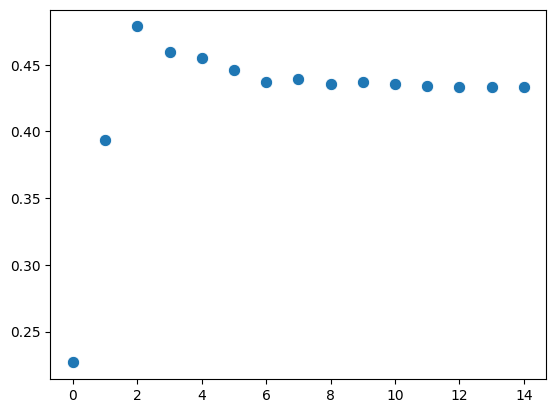

In [18]:
print(len(r2lists[14]))
means = [np.mean(list) for list in r2lists]
# sns.lineplot(means)
sns.scatterplot(means, s=80)
print(list_dfc[0].to_string())

In [18]:
print(exceptionlist)
# print(repeats)

dataframe = pd.DataFrame(exceptionlist)

dataframe.to_csv('Exceptions.csv')

repeat_H_excluded = []

repeat_gamble_excluded = []

for i in exceptionlist:
    repeat_gamble_excluded.append(participants[i+1])

for i in repeats:
    repeat_H_excluded.append(participants[i+1])

repeat_H_excluded[0]

[41, 60, 63, 79, 81, 162, 172, 223, 226, 234, 256, 258, 269, 291, 360, 361, 362, 366, 419, 421, 422, 434, 465, 485, 494, 509, 537, 545, 549, 579, 585, 599, 602, 618, 666, 670, 753, 764, 769, 789, 791, 833, 858, 859, 868, 899, 914, 918, 932, 946, 948, 978, 35, 795]


NameError: name 'repeats' is not defined